## TensorFlow实现CNN识别MNIST

### 什么是卷积神经网络
卷积神经网络（Convolutional Neural Networks-简称CNN），是目前深度学习中最常见、应用最广泛的一种网络，适合于解决图像识别，图片分类，图像预测的问题。

一个典型的图片分类算法就是提取特征，比较特征。CNN 网络简单来说就是将这个过程自动化，开发人员不需要告诉网络图片的特征是什么，CNN 网络可以自动的从图片中寻找特征，并记录。

### MNIST
MNIST 问题是很常见的图片分类问题，训练集是已经编码过的手写图片，图片中是手写的 0~9 的数字，模型经过训练后，输入一张图片，可以输出 0~9 的数字。

MNIST数据集是由**6万张**训练图片和**1万张**测试图片构成的，每张图片都是28*28大小（如下图），而且都是黑白色构成（这里的黑色是一个0-1的浮点数，黑色越深表示数值越靠近1）。

[MNIST数据下载](http://yann.lecun.com/exdb/mnist/)

### 本实验目的

本实验主要通过TensorFlow搭建CNN模型对MNIST进行数字识别，让学生对卷积神经网络（CNN）的原理及构成有一定的了解，如输入层，卷积层等知识点的掌握。

### 加载数据
1. 根据TensorFlow框架里所提供的数据加载方法下载所需的数据；
2. 事先将数据下载到本地，加载数据到实验环境中（防止网络加载慢等问题）。

### 卷积–>池化–>卷积–>池化–>全连接层–>softmax层的卷积神经网络

Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
step 0,training accuracy 0.16
step 1000,training accuracy 0.96
step 2000,training accuracy 0.94
step 3000,training accuracy 1
step 4000,training accuracy 0.98
step 5000,training accuracy 1
step 6000,training accuracy 1
step 7000,training accuracy 1
step 8000,training accuracy 1
step 9000,training accuracy 0.98
step 10000,training accuracy 1
step 11000,training accuracy 0.98
step 12000,training accuracy 1
step 13000,training accuracy 1
step 14000,training accuracy 1
step 15000,training accuracy 1
step 16000,training accuracy 1
step 17000,training accuracy 1
step 18000,training accuracy 1
step 19000,training accuracy 1
test accuracy 0.9912


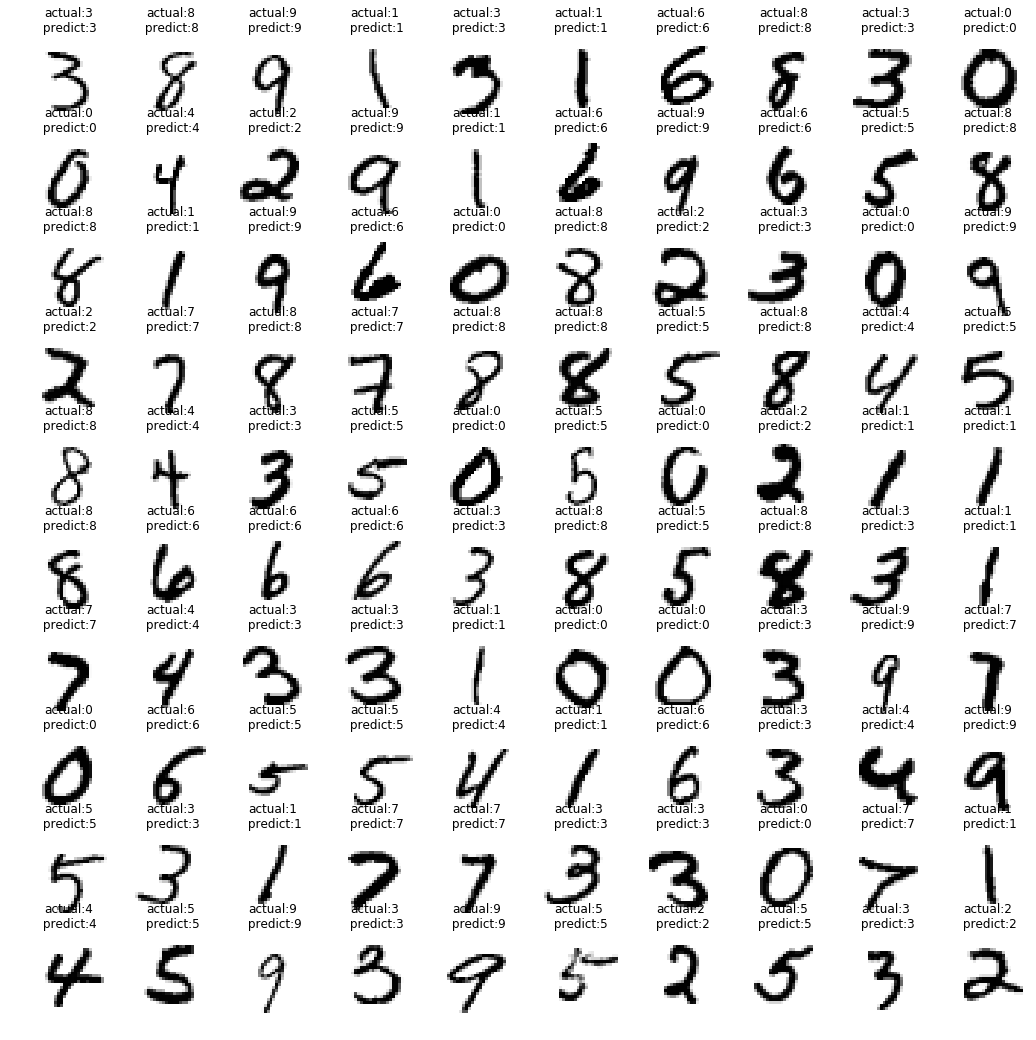

In [42]:
# 引入各个依赖包
%matplotlib inline
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data
import tensorflow as tf
import numpy as np


def weight_variable(shape):
    '''
    使用卷积神经网络会有很多权重和偏置需要创建,我们可以定义初始化函数便于重复使用
    这里我们给权重制造一些随机噪声避免完全对称,使用截断的正态分布噪声,标准差为0.1
    :param shape: 需要创建的权重Shape
    :return: 权重Tensor
    '''
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)


def bias_variable(shape):
    '''
    偏置生成函数,因为激活函数使用的是ReLU,我们给偏置增加一些小的正值(0.1)避免死亡节点(dead neurons)
    :param shape:
    :return:
    '''
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv2d(x, W):
    '''
    卷积层接下来要重复使用,tf.nn.conv2d是Tensorflow中的二维卷积函数,
    :param x: 输入 例如[5, 5, 1, 32]代表 卷积核尺寸为5x5,1个通道,32个不同卷积核
    :param W: 卷积的参数
    strides:代表卷积模板移动的步长,都是1代表不遗漏的划过图片的每一个点.
    padding:代表边界处理方式,SAME代表输入输出同尺寸
    :return:
    '''
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding="SAME")

def max_pool_2x2(x):
    '''
    tf.nn.max_pool是TensorFLow中最大池化函数.我们使用2x2最大池化
    因为希望整体上缩小图片尺寸,因而池化层的strides设为横竖两个方向为2步长
    :param x:
    :return:
    '''
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="SAME")


def draw_digit(position, image, title, is_True):
    '''
    画图 检查数据识别结果
    '''
    plt.subplot(*position)
    plt.imshow(image.reshape(-1, 28), cmap='gray_r')
    plt.axis('off')
    if not is_True:
        plt.title(title, color='red')
    else:
        plt.title(title)
        

def train(mnist):
    # 使用占位符
    x = tf.placeholder(tf.float32, [None, 784])     # x为特征
    y_ = tf.placeholder(tf.float32, [None, 10])     # y_为label
 
    # 卷积中将1x784转换为28x28x1  [-1,,,]代表样本数量不变 [,,,1]代表通道数
    x_image = tf.reshape(x, [-1, 28, 28, 1])
 
    # 第一个卷积层  [5, 5, 1, 32]代表 卷积核尺寸为5x5,1个通道,32个不同卷积核
    # 创建滤波器权值-->加偏置-->卷积-->池化
    W_conv1 = weight_variable([5, 5, 1, 32])
    b_conv1 = bias_variable([32])
    h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1)+b_conv1) #28x28x1 与32个5x5x1滤波器 --> 28x28x32
    h_pool1 = max_pool_2x2(h_conv1)  # 28x28x32 -->14x14x32
 
    # 第二层卷积层 卷积核依旧是5x5 通道为32   有64个不同的卷积核
    W_conv2 = weight_variable([5, 5, 32, 64])
    b_conv2 = bias_variable([64])
    h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2) #14x14x32 与64个5x5x32滤波器 --> 14x14x64
    h_pool2 = max_pool_2x2(h_conv2)  #14x14x64 --> 7x7x64
 
    # h_pool2的大小为7x7x64 转为1-D 然后做FC层
    W_fc1 = weight_variable([7*7*64, 500])
    b_fc1 = bias_variable([500])
    h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])    #7x7x64 --> 1x3136
    h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)  #FC层传播 3136 --> 1024
 
    # 使用Dropout层减轻过拟合,通过一个placeholder传入keep_prob比率控制
    # 在训练中,我们随机丢弃一部分节点的数据来减轻过拟合,预测时则保留全部数据追求最佳性能
    keep_prob = tf.placeholder(tf.float32)
    h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)
 
    # 将Dropout层的输出连接到一个Softmax层,得到最后的概率输出
    W_fc2 = weight_variable([500, 10])  #MNIST只有10种输出可能
    b_fc2 = bias_variable([10])
    y_conv = tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)
 
    # 定义损失函数,依旧使用交叉熵  同时定义优化器  learning rate = 1e-4
    cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_*tf.log(y_conv),reduction_indices=[1]))
    train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
 
    # 定义评测准确率
    correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
 
    #开始训练
    with tf.Session() as sess:
        init_op = tf.global_variables_initializer() #初始化所有变量
        sess.run(init_op)

        STEPS = 20000
        for i in range(STEPS):
            # next_batch函数，它可以从所有的训练数据中读取一小部分作为一个训练batch
            batch = mnist.train.next_batch(50)
        
            if i % 1000 == 0:
                train_accuracy = sess.run(accuracy, feed_dict={x: batch[0], y_: batch[1], keep_prob: 1.0})
                print('step %d,training accuracy %g' % (i, train_accuracy))
            sess.run(train_step, feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.5})
 
        acc = sess.run(accuracy, feed_dict={x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0})
        print("test accuracy %g" % acc)
        
        # 对数据进行识别结果输出
        images,labels = mnist.test.next_batch(100)
        predict_labels = sess.run(y_conv, feed_dict={x:images, y_:labels, keep_prob:1.0})
        image_number = images.shape[0]
        row_number = math.ceil(image_number ** 0.5)
        column_number = row_number
        plt.figure(figsize=(row_number+8, column_number+8))
        for i in range(row_number):
            for j in range(column_number):
                index = i * column_number + j
                if index < image_number:
                    position = (row_number, column_number, index+1)
                    image = images[index]
                    actual = np.argmax(labels[index])
                    predict = np.argmax(predict_labels[index])
                    is_True = actual==predict
                    title = 'actual:%d\n predict:%d' %(actual,predict)
                    draw_digit(position, image, title, is_True)


mnist = input_data.read_data_sets("./data/", one_hot=True) # 载入数据集
train(mnist)
plt.show()

Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz


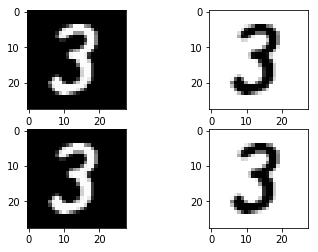

In [43]:
# 对MNIST数据进行 图片可视化输出
import matplotlib.pyplot as plt
 
from tensorflow.contrib.learn.python.learn.datasets.mnist import read_data_sets
 
mnist = read_data_sets('./data/', one_hot=False)
x, y = mnist.test.next_batch(2)
x = x[0].reshape([28, 28])
 
fig = plt.figure()
# Method1 
ax1 = fig.add_subplot(221)
ax1.imshow(x, cmap=plt.cm.gray)
 
# Method2: 反转色
ax2 = fig.add_subplot(222)
ax2.imshow(x, cmap=plt.cm.gray_r) # r表示reverse
 
# Method3（等价于Method1）
ax3 = fig.add_subplot(223)
ax3.imshow(x, cmap='gray')
 
# Method4（等价于Method2）
ax4 = fig.add_subplot(224)
ax4.imshow(x, cmap='gray_r')
 
plt.show()
